In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1 Data Exploration

In [2]:
raw_data_folder = 'data/raw/'
books = pd.read_csv(raw_data_folder + 'books.csv')
tags = pd.read_csv(raw_data_folder + 'tags.csv')
tags = tags.merge(pd.read_csv(raw_data_folder + 'book_tags.csv'), how='inner', on='tag_id')
ratings = pd.read_csv(raw_data_folder + 'ratings.csv')

In [3]:
nodes_books = books[['book_id', 'goodreads_book_id', 'authors', 'original_publication_year', 'title', 'language_code', 'average_rating', 'ratings_count']].copy()
english_variants = [x for x in nodes_books.language_code.unique() if pd.notnull(x) and x.find('en') != -1]
nodes_books['language_code'] = nodes_books.language_code.apply(lambda x: x if x not in english_variants else 'en')
nodes_books['node_id'] = 'b_' + nodes_books['book_id'].astype(str)
nodes_books.sample(5)

,book_id,goodreads_book_id,authors,original_publication_year,title,language_code,average_rating,ratings_count,node_id
2619,2620,6667,"Roald Dahl, Quentin Blake",1984.0,Boy: Tales of Childhood,en,4.09,38240,b_2620
9627,9628,78972,Jeffrey Archer,1996.0,The Fourth Estate,en,3.72,8829,b_9628
6815,6816,148809,Jasper Fforde,2006.0,"The Fourth Bear (Nursery Crime, #2)",en,4.07,16851,b_6816
36,37,100915,C.S. Lewis,1950.0,"The Lion, the Witch, and the Wardrobe (Chronic...",en,4.19,1531800,b_37
4580,4581,4932435,Melina Marchetta,2008.0,"Finnikin of the Rock (Lumatere Chronicles, #1)",en,3.93,29401,b_4581


In [4]:
'''
Step 1: Crosstab to get counts of each rating per user
Step 2: Compute total ratings count and average rating per user
Step 3: Merge the crosstab result with the user stats
Step 4: Rename the rating columns
Step 5: Fill NaN values with 0 for users who have no ratings in some categories
'''

rating_counts = pd.crosstab(ratings['user_id'], ratings['rating'])
user_stats = ratings.groupby('user_id').agg(ratings=('book_id', 'count'),
                                            average_rating=('rating', 'mean'))

nodes_users = user_stats.merge(rating_counts, left_index=True, right_index=True, how='left')
nodes_users.columns = ['ratings', 'average_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
nodes_users = nodes_users.fillna(0).reset_index()
nodes_users['node_id'] = 'u_' + nodes_users['user_id'].astype(str)
nodes_users.sample(5)


,user_id,ratings,average_rating,rating_1,rating_2,rating_3,rating_4,rating_5,node_id
4311,4312,119,3.369748,4,23,41,27,24,u_4312
31978,31979,85,3.752941,5,5,11,49,15,u_31979
19052,19053,79,4.759494,0,0,1,17,61,u_19053
2122,2123,98,4.030612,0,4,16,51,27,u_2123
16129,16130,148,4.121622,0,0,28,74,46,u_16130


In [5]:
print('nodes_books.columns:', nodes_books.columns)
print('nodes_users.columns:', nodes_users.columns)
print('ratings.columns:', ratings.columns)

nodes_books.columns: Index(['book_id', 'goodreads_book_id', 'authors', 'original_publication_year',
       'title', 'language_code', 'average_rating', 'ratings_count', 'node_id'],
      dtype='object')
nodes_users.columns: Index(['user_id', 'ratings', 'average_rating', 'rating_1', 'rating_2',
       'rating_3', 'rating_4', 'rating_5', 'node_id'],
      dtype='object')
ratings.columns: Index(['user_id', 'book_id', 'rating'], dtype='object')


# 2 Graph

Using the ratings dataset of the Goodreads-10k dataset, we want to create a directed bipartite graph with two types of nodes: users and books. The edge between a user and a book represents a rating.

### 2.1 Construct the Graph

Sample the dataset to work with a smaller graph:

In [6]:
sample_nodes_books = nodes_books.sample(500)
sample_nodes_users = nodes_users.sample(1000)
sample_edges_ratings = ratings[(ratings.book_id.isin(sample_nodes_books.book_id)) & (ratings.user_id.isin(sample_nodes_users.user_id))]

Construct a networkx graph:

In [7]:
G = nx.DiGraph()

# Add book nodes
for _, row in tqdm(sample_nodes_books.iterrows(), desc='Add book-nodes'):
    G.add_node(row['node_id'],
               node_type='book')

# Add user nodes
for _, row in tqdm(sample_nodes_users.iterrows(), desc='Add user-nodes'):
    G.add_node(row['node_id'], 
               node_type='user')
    
# Add edges (ratings)
for _, row in tqdm(sample_edges_ratings.iterrows(), desc='Add rating-edges'):
    G.add_edge(f"u_{row['user_id']}", f"b_{row['book_id']}", rating=row['rating'])

# Add edges (to reads)
#to_reads_df = pd.read_csv(raw_data_folder + 'to_read.csv')
#sample_edges_to_reads = to_reads_df[(to_reads_df.book_id.isin(sample_nodes_books.book_id)) & (to_reads_df.user_id.isin(sample_nodes_users.user_id))]
#for _, row in tqdm(sample_edges_to_reads.iterrows(), desc='Add to-read-edges'):
#    G.add_edge(f"u_{row['user_id']}", f"b_{row['book_id']}", rating=-1)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Add book-nodes: 500it [00:00, 14903.54it/s]
Add user-nodes: 1000it [00:00, 16533.51it/s]
Add rating-edges: 5470it [00:00, 18870.20it/s]

Graph has 1500 nodes and 5470 edges.


Remove isolated nodes:

In [8]:
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
print(f"Removed {len(isolated_nodes)} isolated nodes.")

Removed 25 isolated nodes.


Verify that it is bipartite:

In [9]:
from networkx.algorithms import bipartite
is_bipartite = bipartite.is_bipartite(G)
print(f"Graph is bipartite: {is_bipartite}")

Graph is bipartite: True


In [10]:
nx.write_graphml(G, "data/bipartite_sample_w_to_reads.graphml")

Create and save graph with to_read edges

### 2.2 Convert Graph to Torch Geometric

In [11]:
from torch_geometric.utils import from_networkx

data = from_networkx(G)

# 3 Pipeline

### 3.2 Off-limits Link Prediction (Neural Graph Collaborative Filtering)

In [12]:
ngcf_link_predictor_folder = "data/ngcf_link_predictor/"

In [13]:
from src.ngcf import NGCF
import pandas as pd
import torch
import networkx as nx
from sklearn.model_selection import train_test_split

import os
from time import time
from datetime import datetime

from src.ngcf_utils.load_data import Data
from src.ngcf_utils.parser import parse_args
from src.ngcf_utils.helper_functions import early_stopping,\
                                   train,\
                                   split_matrix,\
                                   compute_ndcg_k,\
                                   eval_model,\
                                   probability_matrix
from src.ngcf import NGCF

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
import wandb

try:
    wandb.finish()
except:
    pass

wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaede-johnson (hans-kvaerum). Use `wandb login --relogin` to force relogin


True

In [15]:
# load in sample of book dataset
G = nx.read_graphml("data/bipartite_sample_w_to_reads.graphml")

# create node name to index mapping
## based on codebase for NGCF, indices for both sets start at 0!
user_nodes = {node for node, node_type in G.nodes(data=True) if node_type['node_type'] == 'user'}
book_nodes = {book for book, node_type in G.nodes(data=True) if node_type['node_type'] == 'book'}
book_to_idx_map = {node: i for i, node in enumerate(book_nodes)}
user_to_idx_map = {node: i for i, node in enumerate(user_nodes)}

# this is a link predictor. link = desire for interaction. this includes ratings and to_reads
# split into train and test
edges = list(G.edges())
train_edges, test_edges = train_test_split(edges, test_size=0.2, random_state=5)
train_graph = G.edge_subgraph(train_edges)
test_graph = G.edge_subgraph(test_edges)

# save train and test in format suited for NGCF codebase
def save_graph_edges_to_txt(G, filename):
    with open(filename, 'w') as file:
        for node, data in G.nodes(data=True):
            if data['node_type'] == 'user':
                user_node = node # just to make following commands clearer
                neighbors = list(G.neighbors(user_node))
                user_node_remapped = user_to_idx_map[user_node]
                line = f"{user_node_remapped} " + " ".join(map(str, [book_to_idx_map[neighbor] for neighbor in neighbors]))
                file.write(line + '\n')
save_graph_edges_to_txt(train_graph, ngcf_link_predictor_folder + "ngcf_train.txt")
save_graph_edges_to_txt(test_graph, ngcf_link_predictor_folder + "ngcf_test.txt")

In [16]:
# set hyperparameters
batch_size = 16
layers = [16, 32]
emb_dim = 52
lr = 0.015
reg = 0.005
mess_dropout = 0.01
node_dropout = 0.01
k = 20
n_epochs = 50
user_count = len(user_to_idx_map.keys())
book_count = len(book_to_idx_map.keys())
save_results = True
eval_N = 4 # how often to print eval results
pos_weight = '20'

# create model name
modelname =  "NGCF_ntr_bceloss_cutoff0.9_" + \
    "_bs_" + str(batch_size) + \
    "_nemb_" + str(emb_dim) + \
    "_layers_" + str(layers) + \
    "_nodedr_" + str(node_dropout) + \
    "_messdr_" + str(mess_dropout) + \
    "_reg_" + str(reg) + \
    "_lr_"  + str(lr) + \
    "_bcount_" + str(book_count) + \
    "_ucount_" + str(user_count) + \
    "_posweight_" + str(pos_weight)

# set wandb init
wandb.init(
    
    # set the wandb project where this run will be logged
    project="nml_project",

    # name run
    name=modelname,
    
    # track hyperparameters and run metadata
    config={
    "architecture": "NGCF",
    "batch_size": batch_size,
    "layers": layers,
    "emb_dim": emb_dim,
    "lr": lr,
    "reg": reg,
    "mess_dropout": mess_dropout,
    "node_dropout": node_dropout,
    "k": k,
    "epochs": n_epochs,
    "user_count": user_count,
    "book_count": book_count,
    }
)

n_users=994, n_items=481
n_interactions=5470
n_train=4376, n_test=1094, sparsity=0.01144
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.0703573226928711 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1475, 1475) 0.054048776626586914 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...
Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.020021677017211914 sec.
Initializing weights...
Weights initialized.


c:\Users\HP\Documents\GitHub\EE452_2024_Team5_Project\src\ngcf_utils\load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()


Epoch: 0, Training time: 9.83s, Loss: 178.9050
Epoch: 1, Training time: 10.20s, Loss: 151.1603
Epoch: 2, Training time: 9.94s, Loss: 119.5487
Epoch: 3, Training time: 9.76s, Loss: 104.7804
Counter({1.0: 1094})
13322 232 1094 (994, 481) torch.Size([994, 100]) torch.Size([481, 100]) (994, 481)
Epoch: 4, Training time: 11.66s, Loss: 93.1198
Epoch: 5, Training time: 12.10s, Loss: 84.1515
Epoch: 6, Training time: 11.29s, Loss: 75.7213
Epoch: 7, Training time: 11.19s, Loss: 74.5298
Counter({1.0: 1094})
8202 232 1094 (994, 481) torch.Size([994, 100]) torch.Size([481, 100]) (994, 481)
Epoch: 8, Training time: 11.04s, Loss: 71.5043
Epoch: 9, Training time: 11.17s, Loss: 69.2395
Epoch: 10, Training time: 11.28s, Loss: 68.5942
Epoch: 11, Training time: 11.41s, Loss: 67.5908
Counter({1.0: 1094})
6348 199 1094 (994, 481) torch.Size([994, 100]) torch.Size([481, 100]) (994, 481)
Epoch: 12, Training time: 10.98s, Loss: 67.7819
Epoch: 13, Training time: 11.22s, Loss: 68.2404
Epoch: 14, Training time: 1

ndcg_20,▁▇█▇▇▄▅▅
rec_20,▁▇█▇▇▄▃▄
test_f1_score,▁▆▇▇█▆▅▄
test_precision,▁▅▇▇█▆▆▅
test_recall,██▆▅▅▃▂▁
training_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ndcg_20,0.13407
rec_20,0.20573
test_f1_score,0.04421
test_precision,0.02725
test_recall,0.117


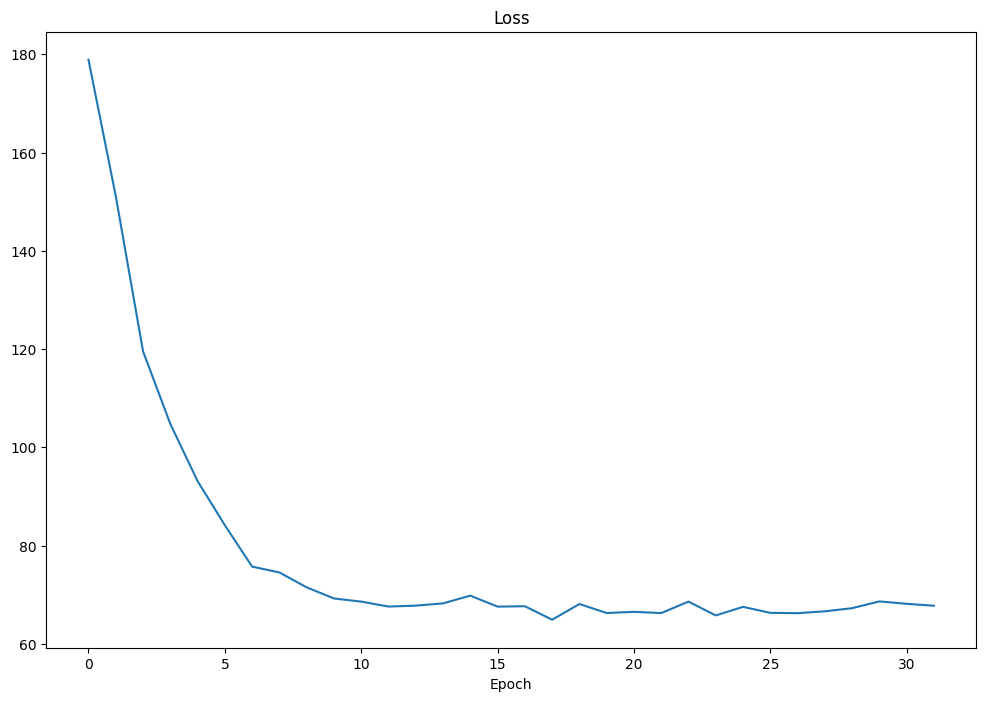

In [17]:
import matplotlib.pyplot as plt

# generate the NGCF-adjacency matrix
data_generator = Data(path=ngcf_link_predictor_folder, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

# using bce loss w weight rebalancing due to sparsity of matrix
pos_weight = 1 / (adj_mtx.nnz / (user_count * book_count))
pos_weight = 20

# create NGCF model
model = NGCF(user_count, 
                 book_count,
                 emb_dim,
                 layers,
                 reg,
                 node_dropout,
                 mess_dropout,
                 adj_mtx,
                 pos_weight)
if use_cuda:
    model = model.cuda()

# current best metric
cur_best_metric = 0

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Set values for early stopping
cur_best_loss, stopping_step, should_stop = 1e3, 0, False
today = datetime.now()

results = {"Epoch": [],
            "Loss": [],
            "Recall": [],
            "NDCG": [],
            "Training Time": []}

for epoch in range(n_epochs):

    t1 = time()
    loss = train(model, data_generator, optimizer)
    training_time = time()-t1
    print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
        format(epoch, training_time, loss))

    wandb.log({"training_loss": loss})
    
    # print test evaluation metrics every N epochs (provided by eval_N)
    if epoch % eval_N  == (eval_N - 1):
        with torch.no_grad():
            t2 = time()
            recall, ndcg = eval_model(model.u_g_embeddings.detach().to(device),
                                        model.i_g_embeddings.detach().to(device),
                                        data_generator.R_train,
                                        data_generator.R_test,
                                        k,
                                        device)
        #print(
        #    "Evaluate current model:\n",
        #    "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
        #    "Loss: {:.4f}:".format(loss), "\n",
        #    "Recall@{}: {:.4f}".format(k, recall), "\n",
        #    "NDCG@{}: {:.4f}".format(k, ndcg)
        #    )

        cur_best_metric, stopping_step, should_stop = \
        early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)

        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(recall.item())
        results['NDCG'].append(ndcg.item())
        results['Training Time'].append(training_time)

        p_mat, test_recall, test_precision, test_f1_score = probability_matrix(model.u_g_embeddings.detach().to(device),
                                        model.i_g_embeddings.detach().to(device),
                                        data_generator.R_train,
                                        data_generator.R_test,
                                        device)
        
        wandb.log({f"test_recall": test_recall, f"test_precision": test_precision, f"test_f1_score": test_f1_score, f"rec_{k}": recall.item(), f"ndcg_{k}": ndcg.item()})       

    else:
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(None)
        results['NDCG'].append(None)
        results['Training Time'].append(training_time)

    if should_stop == True: break

wandb.finish()

# save
if save_results:
    date = today.strftime("%d%m%Y_%H%M")

    # save model as .pt file
    if os.path.isdir(ngcf_link_predictor_folder + "/models"):
        torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models" + str(date) + "_" + modelname + ".pt")
    else:
        os.mkdir(ngcf_link_predictor_folder + "/models")
        torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models" + str(date) + "_" + modelname + ".pt")

    # save results as pandas dataframe
    results_df = pd.DataFrame(results)
    results_df.set_index('Epoch', inplace=True)
    if os.path.isdir(ngcf_link_predictor_folder + "/results"):
        results_df.to_csv(ngcf_link_predictor_folder + "/results" + str(date) + "_" + modelname + ".csv")
    else:
        os.mkdir(ngcf_link_predictor_folder + "/results")
        results_df.to_csv(ngcf_link_predictor_folder + "/results" + str(date) + "_" + modelname + ".csv")
    # plot loss
    results_df['Loss'].plot(figsize=(12,8), title='Loss')

---

old below...

# 3 Recommender System Architectures

In this section, we will implement and apply different recommender system architectures to the Goodreads-10k dataset. 

The architectures we want to test are:
1. Graph Convolutional Network (GCN)
2. Graph Attention Network (GATv2)


### Perplexity Recommedations:

1. **Graph Convolutional Networks (GCNs):** are a type of GNN that operate directly on the graph structure, allowing information to propagate between nodes along the edges of the graph. They can effectively capture high-order relationships between users and items by aggregating information from neighbors. GCNs have been widely used in recommender systems to learn latent representations of users and items from the user-item interaction graph.
2. **GraphSAGE (Graph Sample and AggregatE):** is a highly scalable GNN architecture that can generate node embeddings by sampling and aggregating features from a node's neighborhood. It uses an inductive learning approach, allowing it to generalize to unseen nodes, making it suitable for dynamic recommendation scenarios. GraphSAGE's sampling technique and aggregation function flexibility make it a popular choice for large-scale recommender systems.
3. **Knowledge Graph Attention Network (KGAT):** is a GNN-based model that incorporates knowledge graphs to enhance item representations. It constructs a heterogeneous graph consisting of users, items, and item attributes as nodes. KGAT recursively propagates and aggregates embeddings from neighboring nodes using an attention mechanism, capturing the importance of different neighbors. This approach leverages both user-item interactions and item knowledge for improved recommendations.
4. **Edge-Enhanced Graph Neural Networks (EGNNs):** also known as Edge GraphSAGE or Enhanced Graph Neural Networks, extend the GraphSAGE model by incorporating edge features in addition to node features. In recommender systems, EGNNs can capture the type and strength of connections between users and items, leading to more accurate and personalized recommendations by modeling both node-level and edge-level interactions.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

class BaseRecommender(nn.Module):
    def __init__(self):
        super(BaseRecommender, self).__init__()

    def forward(self, data):
        raise NotImplementedError("This method needs to be implemented by subclasses.")

    def train_model(self, data, epochs, lr):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        for epoch in range(epochs):
            self.train()
            optimizer.zero_grad()
            output = self(data)
            loss = criterion(output[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    def evaluate(self, data):
        self.eval()
        with torch.no_grad():
            output = self(data)
            mse = ((output[data.test_mask] - data.y[data.test_mask]) ** 2).mean().item()
        return mse



## 3.1 Graph Convolutional Networks (GCN)

# LightGCN

In [14]:
%%capture
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-geometric
#!pip install -q git+https://github.com/snap-stanford/deepsnap.git
#!pip install -U -q PyDrive

In [15]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

In [16]:
# create edge_index
CUTOFF = 4 # rating needs to be higher than this for edge to exist
sample_edges_ratings.loc[:, 'user_id_new'] = sample_edges_ratings['user_id'].rank(method='dense').astype(int) - 1
sample_edges_ratings.loc[:, 'book_id_new'] = sample_edges_ratings['book_id'].rank(method='dense').astype(int) - 1
edge_index = torch.tensor(sample_edges_ratings[sample_edges_ratings['rating'] > CUTOFF][['user_id_new', 'book_id_new']].values.T, dtype=torch.long)

C:\Users\HP\AppData\Local\Temp\ipykernel_25328\2714468263.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_edges_ratings.loc[:, 'user_id_new'] = sample_edges_ratings['user_id'].rank(method='dense').astype(int) - 1
C:\Users\HP\AppData\Local\Temp\ipykernel_25328\2714468263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_edges_ratings.loc[:, 'book_id_new'] = sample_edges_ratings['book_id'].rank(method='dense').astype(int) - 1


In [17]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_books = max(sample_edges_ratings['user_id_new']), max(sample_edges_ratings['book_id'])
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [18]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_books, num_users + num_books))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_books, num_users + num_books))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_books, num_users + num_books))

In [19]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [20]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_books)

In [21]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [22]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [23]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [24]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [25]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [26]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

In [27]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [28]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [29]:
# training loop
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
        BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(
        device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

IndexError: index 989 is out of bounds for dimension 0 with size 989

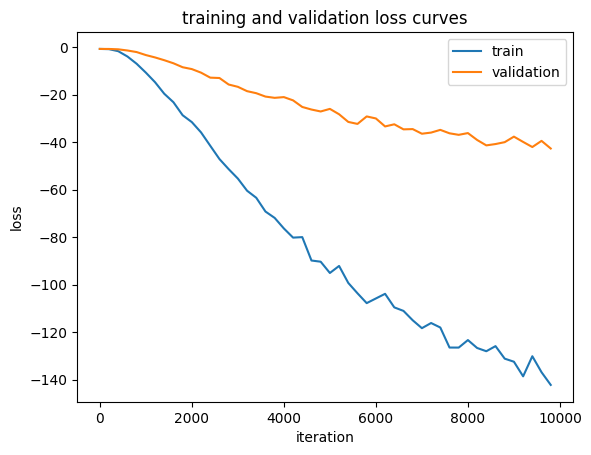

In [23]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [24]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -33.90347, test_recall@20: 0.29701, test_precision@20: 0.01731, test_ndcg@20: 0.14167


In [ ]:
# to be implemented...

In [25]:
user_pos_items = get_user_positive_items(edge_index)

def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some movies that user {user_id} rated highly")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

    print()

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some suggested movies for user {user_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

notes:

lack of rating may not be as bad as not giving a rating 
make sure you're sampling in a logical way - verify that you're keeping the pertinent properties of your graph
networkx is pretty general - look into packages that are specifically catered toward individual methods, as they'll be faster
pytorch geometric can be used to handle big graphs. sample true and SGD on stuff.
just look at the literature for evaluating recommender systems, as well as how expected. netflix challenge could be a good place for benchmark.

